In [201]:
import os, sys, pickle

import matplotlib.pyplot as plt
import numpy as np
import collections
%matplotlib inline 
import os

import jp_mpl as jplot

from scipy import optimize
from matplotlib.colors import LogNorm
import pickle

# My tools
import jp_analysis as analysis
import ratdb_reader
reload(ratdb_reader)

from copy import deepcopy
import itertools

In [202]:
infile_name = '/home/jpyanez/snoplus/software/rat/data/PMTTRANSIT.ratdb'
dbdata = ratdb_reader.dbreader(infile_name)

reader: Creating a dict in line 4
reader: Closing a dict in line 17
reader: Creating a dict in line 19
reader: Closing a dict in line 34


In [203]:
dbdata['r1408'].keys()

['run_range',
 'index',
 'type',
 'timestamp',
 'comment',
 'version',
 'pass',
 'y',
 'x',
 'cable_delay']

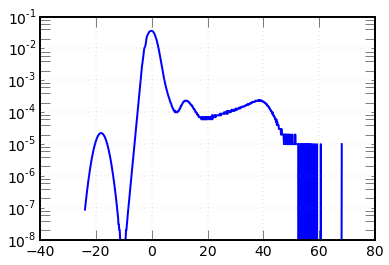

In [204]:
from scipy import interpolate
plt.figure()
plt.plot(dbdata['r1408']['x'][1:], dbdata['r1408']['y'][1:] - dbdata['r1408']['y'][:-1])
plt.yscale('log')
#plt.figure()
#plt.plot(apTime[1:],apProb[1:]-apProb[:-1])

lpfcn = interpolate.InterpolatedUnivariateSpline(dbdata['r1408']['x'][1:], 
                                                 dbdata['r1408']['y'][1:] - dbdata['r1408']['y'][:-1])
#xaxis = np.linspace(550, 10000, 501)
#plt.plot(xaxis, apfcn(xaxis))
mytime  = np.linspace(-10, 80, 1001)-mytime[mylatep.argmax()]
mylatep = lpfcn(mytime)

## Using the same input files used for the reflection fit

In [205]:
# PMT information
pmt_info = pickle.load(open('/home/jpyanez/snoplus/snoplus_python/pmt_positions.pckl'))
lowgain = pmt_info['type']==3
#low_gain pmts are type==3

In [222]:
# All the usable runs
usable_run_list =  [17375,
100556,
100558,
101427,
101428,
101432,
101433,
102518,
102529,
102552,
102554,
102570,
102572,
102574]
# very high stats runs
usable_run_list =  [102574,
                    17375,
                    102552,
                    102554,
                    
                    #100556,
                    #100558,
                    #101428,
                    #101432,
                    #102529,
                    ]
# Use only 420 nm 
usable_run_list =  [17386,17384,
    101152,
                    101158,
                    101161,
                    17375,
100556,
100558,
101428,
101432,
102572,
102574]

In [223]:
# Location of data
lb_hist_dir  = '/home/jpyanez/snoplus/data/SOC_histograms_python_backup'
lb_file_list = os.listdir(lb_hist_dir)
lb_file_list = [x for x in lb_file_list if 'pckl' in x]
final_lb_list = []
for one_run in usable_run_list:
    for one_file in lb_file_list:
        if str(one_run) in one_file:
            final_lb_list.append(one_file)
            continue

In [224]:
print final_lb_list

['SOC_0000017386.pckl', 'SOC_0000017384.pckl', 'SOC_0000101152.pckl', 'SOC_0000101158.pckl', 'SOC_0000101161.pckl', 'SOC_0000017375.pckl', 'SOC_0000100556.pckl', 'SOC_0000100558.pckl', 'SOC_0000101428.pckl', 'SOC_0000101432.pckl', 'SOC_0000102572.pckl', 'SOC_0000102574.pckl']


In [225]:
wavelengths = np.zeros(len(final_lb_list))

for i, one_file in enumerate(final_lb_list):
    try:
        data     = pickle.load(open(os.path.join(lb_hist_dir, one_file)))
    except:
        print one_file
        continue

    if i == 0:
        #print one_file
        #print data['time_residuals'].shape
        all_data = np.zeros(list(data['time_residuals'].shape) + [len(final_lb_list)])
        time_axis = data['residual_axis']

    all_data[:,:,i] = data['time_residuals']
    wavelengths[i] = data['wavelength']
    



0 9765813.0
1 39825283.0
2 6395674.0
3 60296996.0
4 99345947.0
Maximum number of runs reached


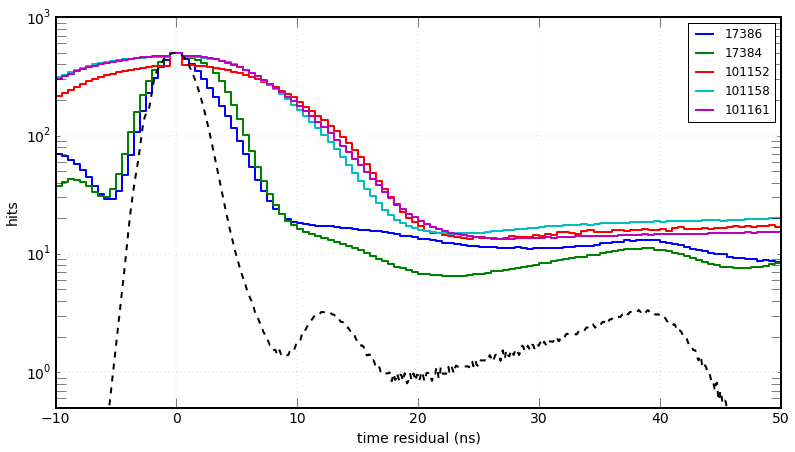

In [228]:
plt.figure(figsize=(13,7))
pmt_nr = np.array([3500])
pmt_nr = pmt_info['type']==1
peak   = 500.
maxruns = 4
mycolors = itertools.cycle(['b','g','r','c','m','brown','darkgreen','darkred'])
for irun in range(all_data.shape[2]):
    # Normalize to 1000
    this_run = all_data[:,pmt_nr, irun].sum(axis=1)
    print irun, this_run.sum()
    jplot.unfilledBar(time_axis, this_run*peak/this_run.max(), color=mycolors.next(),
                     label=str(usable_run_list[irun]))
    if irun >= maxruns:
        print 'Maximum number of runs reached'
        break
        
plt.plot(mytime, mylatep*peak/mylatep.max(), '--k')        

plt.xlabel('time residual (ns)')
plt.ylabel('hits')
plt.yscale('log')
plt.ylim([0.5, 10**3])
plt.xlim([-10, 50])
plt.legend(loc=0)

In [156]:
original_data = deepcopy(all_data)
bins_to_merge = 3
merged_data   =  deepcopy(all_data[:-bins_to_merge, : ,:])
#print all_data.shape, merged_data.shape
for i in range(1, bins_to_merge+1):
    #print 'This is i', i
    if i == bins_to_merge:
        merged_data += all_data[i:, : ,:]
    else:
        #print i, -(i+1), all_data[i:-(bins_to_merge-i), : ,:].shape
        merged_data += all_data[i:-(bins_to_merge-i), : ,:]
        
merged_data = merged_data[::bins_to_merge,:,:]
merged_time = time_axis[::bins_to_merge]
if (merged_time.shape[0] - merged_data.shape[0]) > 1:
    merged_time = merged_time[:-1]
print merged_data.shape, merged_time.shape


(66, 9728, 7) (67,)


0 5799.0
1 10015.0
2 5647.0
3 4617.0
4 10774.0
5 4602.0
6 37533.0


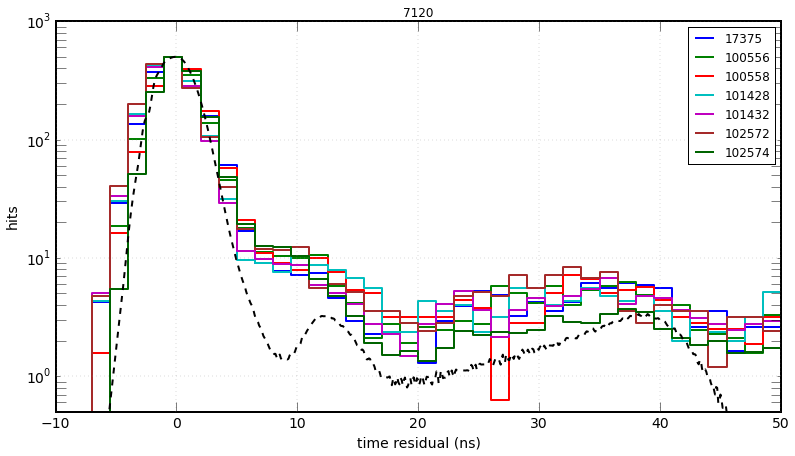

In [199]:
plt.figure(figsize=(13,7))
pmt_nr = np.array([7120])
peak   = 500.
maxruns = 10
mycolors = itertools.cycle(['b','g','r','c','m','brown','darkgreen','darkred'])
for irun in range(merged_data.shape[2]):
    # Normalize to 1000
    this_run = merged_data[:,pmt_nr, irun].sum(axis=1)
    print irun, this_run.sum()
    jplot.unfilledBar(merged_time, this_run*peak/this_run.max(), color=mycolors.next(),
                     label=str(usable_run_list[irun]))
    if irun >= maxruns:
        print 'Maximum number of runs reached'
        break
        
plt.plot(mytime, mylatep*peak/mylatep.max(), '--k')        
plt.title(str(pmt_nr[0]))
plt.xlabel('time residual (ns)')
plt.ylabel('hits')
plt.yscale('log')
plt.ylim([0.5, 10**3])
plt.xlim([-10, 50])
plt.legend(loc=0)